In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


In [15]:

df = pd.read_csv("heat_transfer_ann_dataset.csv")
print(f"Dataset shape: {df.shape}")

df.head()

Dataset shape: (39, 8)


,w/W,Re,f_Experiment,f_ANN,Nu_Experiment,Nu_ANN,η_Experiment,η_ANN
0,0.31,5569,0.3534,0.3500,72.39,72.5212,0.925391,0.9261
1,0.31,6299,0.3448,0.3442,80.35,80.8109,0.914844,0.9133
2,0.31,7012,0.3360,0.3368,90.47,89.6981,0.893750,0.8924
3,0.31,7756,0.3238,0.3281,99.77,99.3401,0.869141,0.8688
4,0.31,8467,0.3203,0.3200,108.87,109.0160,0.858594,0.8501


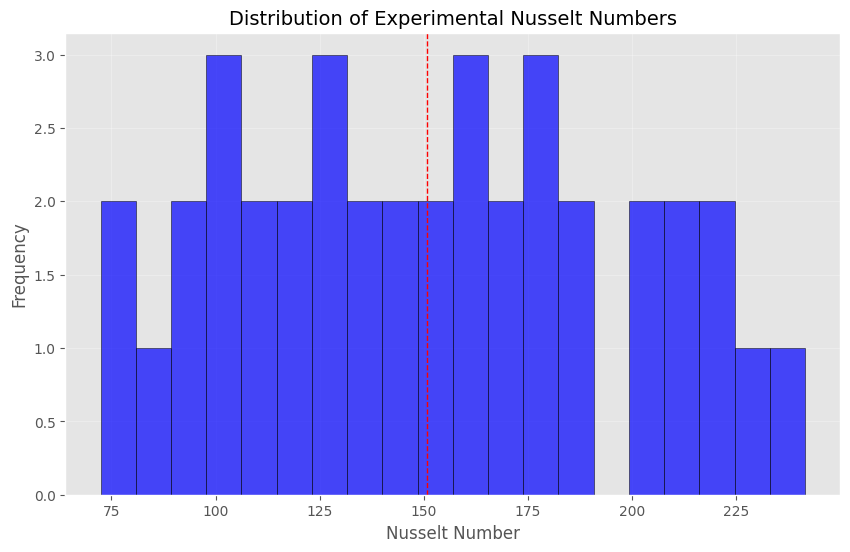

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df["Nu_Experiment"], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(df["Nu_Experiment"].mean(), color='red', linestyle='dashed', linewidth=1)
plt.title("Distribution of Experimental Nusselt Numbers", fontsize=14)
plt.xlabel("Nusselt Number", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
def engineer_features(X):
    """Create physics-informed features for heat transfer prediction"""
    X_new = X.copy()
    X_new['Re_sqrt'] = np.sqrt(X['Re'])      
    X_new['Re_squared'] = X['Re'] ** 2       
    X_new['log_Re'] = np.log(X['Re'])        
    X_new['w_W_squared'] = X['w/W'] ** 2     
    X_new['w_W_cubed'] = X['w/W'] ** 3      
    X_new['w_W_reciprocal'] = 1 / X['w/W']   
    
 
    X_new['w_W_x_Re'] = X['w/W'] * X['Re']             
    X_new['w_W_x_Re_squared'] = X['w/W'] * (X['Re'] ** 2)  
    X_new['w_W_x_sqrt_Re'] = X['w/W'] * np.sqrt(X['Re'])  
    
    return X_new


X = df[["w/W", "Re"]]
y = df["Nu_Experiment"]


X_engineered = engineer_features(X)


X_engineered.head()

,w/W,Re,Re_sqrt,Re_squared,log_Re,w_W_squared,w_W_cubed,w_W_reciprocal,w_W_x_Re,w_W_x_Re_squared,w_W_x_sqrt_Re
0,0.31,5569,74.625733,31013761,8.624971,0.0961,0.029791,3.225806,1726.39,9614265.91,23.133977
1,0.31,6299,79.366240,39677401,8.748146,0.0961,0.029791,3.225806,1952.69,12299994.31,24.603534
2,0.31,7012,83.737686,49168144,8.855378,0.0961,0.029791,3.225806,2173.72,15242124.64,25.958683
3,0.31,7756,88.068155,60155536,8.956222,0.0961,0.029791,3.225806,2404.36,18648216.16,27.301128
4,0.31,8467,92.016303,71690089,9.043932,0.0961,0.029791,3.225806,2624.77,22223927.59,28.525054


In [18]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X_engineered, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


X_train_orig, X_val_orig, X_test_orig = X.iloc[X_train.index], X.iloc[X_val.index], X.iloc[X_test.index]

Training set: 27 samples
Validation set: 6 samples
Test set: 6 samples


In [19]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_orig)
X_val_orig_scaled = scaler_orig.transform(X_val_orig)
X_test_orig_scaled = scaler_orig.transform(X_test_orig)


poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_orig_scaled)
X_val_poly = poly.transform(X_val_orig_scaled)
X_test_poly = poly.transform(X_test_orig_scaled)

print(f"Original features shape: {X_train_orig.shape[1]}")
print(f"Engineered features shape: {X_train.shape[1]}")
print(f"Polynomial features shape: {X_train_poly.shape[1]}")

Original features shape: 2
Engineered features shape: 11
Polynomial features shape: 9


In [20]:

models = {
    "SVR (RBF + Optimized)": {
        "model": SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.05),
        "features": "engineered",
        "description": "Support Vector Regression with RBF kernel and optimized hyperparameters"
    },
    "Voting Ensemble": {
        "model": VotingRegressor([
            ('xgb', XGBRegressor(n_estimators=200, max_depth=3, random_state=42)),
            ('poly', Pipeline([
                ('poly', PolynomialFeatures(degree=2)),
                ('reg', LinearRegression())
            ])),
            ('ridge', Ridge(alpha=0.1))
        ]),
        "features": "original",
        "description": "Ensemble of XGBoost, Polynomial Regression, and Ridge Regression"
    },
    "Gradient Boosting (Opt)": {
        "model": GradientBoostingRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=4, 
            min_samples_split=5, min_samples_leaf=2, subsample=0.8, random_state=42
        ),
        "features": "engineered",
        "description": "Optimized Gradient Boosting with engineered features"
    },
    "Polynomial Regression": {
        "model": LinearRegression(),
        "features": "poly3",
        "description": "Linear regression on 3rd degree polynomial features"
    },
    "Huber Regressor": {
        "model": HuberRegressor(
            epsilon=1.5,
            alpha=0.0001,
            max_iter=2000
        ),
        "features": "original",
        "description": "Robust regression that's less sensitive to outliers"
    }
}


for name, info in models.items():
    print(f"{name}: {info['description']}")
    print(f"   Features used: {info['features']}")
    print()

SVR (RBF + Optimized): Support Vector Regression with RBF kernel and optimized hyperparameters
   Features used: engineered

Voting Ensemble: Ensemble of XGBoost, Polynomial Regression, and Ridge Regression
   Features used: original

Gradient Boosting (Opt): Optimized Gradient Boosting with engineered features
   Features used: engineered

Polynomial Regression: Linear regression on 3rd degree polynomial features
   Features used: poly3

Huber Regressor: Robust regression that's less sensitive to outliers
   Features used: original



In [21]:

results = []


print("\nModel comparison against paper benchmark:")
print("-" * 50)
print(f"{'Model':<25} {'MSE':>10} {'MAE':>10} {'MBE':>10} {'R²':>10}")
print("-" * 50)

for name, model_info in models.items():

    if model_info["features"] == "engineered":
        X_tr, X_v, X_te = X_train_scaled, X_val_scaled, X_test_scaled
    elif model_info["features"] == "original":
        X_tr, X_v, X_te = X_train_orig_scaled, X_val_orig_scaled, X_test_orig_scaled
    elif model_info["features"] == "poly3":
        X_tr, X_v, X_te = X_train_poly, X_val_poly, X_test_poly
    

    model = model_info["model"]
    model.fit(X_tr, y_train)
    

    train_errors = []
    val_errors = []
    test_errors = []
    
    if name in ["Gradient Boosting (Opt)"]:
        
        for i in range(1, 28): 
            model_i = GradientBoostingRegressor(
                n_estimators=i*10, learning_rate=0.05, max_depth=4,
                min_samples_split=5, min_samples_leaf=2, subsample=0.8, random_state=42
            )
            model_i.fit(X_tr, y_train)
       
            train_pred = model_i.predict(X_tr)
            val_pred = model_i.predict(X_v)
            test_pred = model_i.predict(X_te)
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            val_errors.append(mean_squared_error(y_val, val_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))

    y_pred = model.predict(X_te)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mbe = np.mean(y_pred - y_test)
    r2 = r2_score(y_test, y_pred)
    

    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae, 
        "MBE": mbe,
        "R²": r2,
        "Train Errors": train_errors,
        "Val Errors": val_errors,
        "Test Errors": test_errors,
        "Predictions": y_pred
    })
    

    print(f"{name:<25} {mse:>10.4f} {mae:>10.4f} {mbe:>10.4f} {r2:>10.4f}")


Model comparison against paper benchmark:
--------------------------------------------------
Model                            MSE        MAE        MBE         R²
--------------------------------------------------
SVR (RBF + Optimized)         4.2829     1.6544    -0.1884     0.9982
Voting Ensemble              11.1563     2.1877    -0.6915     0.9952
Gradient Boosting (Opt)      18.4496     3.5029    -1.4360     0.9920
Polynomial Regression         8.6255     2.5277     0.5051     0.9963
Huber Regressor              11.7661     2.4175     0.2436     0.9949


In [22]:

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("MSE")

results_df = pd.concat([
    results_df,
    pd.DataFrame([{
        "Model": "Paper Benchmark", 
        "MSE": 2.2344,  
        "MAE": 1.6350,  
        "MBE": -0.9130, 
        "R²": None      
    }])
])

print("\nResults Summary (sorted by MSE):")
print(results_df[["Model", "MSE", "MAE", "MBE", "R²"]].to_string(index=False))


Results Summary (sorted by MSE):
                  Model       MSE      MAE       MBE       R²
  SVR (RBF + Optimized)  4.282867 1.654353 -0.188447 0.998151
  Polynomial Regression  8.625478 2.527696  0.505101 0.996277
        Voting Ensemble 11.156337 2.187706 -0.691507 0.995184
        Huber Regressor 11.766071 2.417515  0.243572 0.994921
Gradient Boosting (Opt) 18.449611 3.502879 -1.435967 0.992036
        Paper Benchmark  2.234400 1.635000 -0.913000      NaN


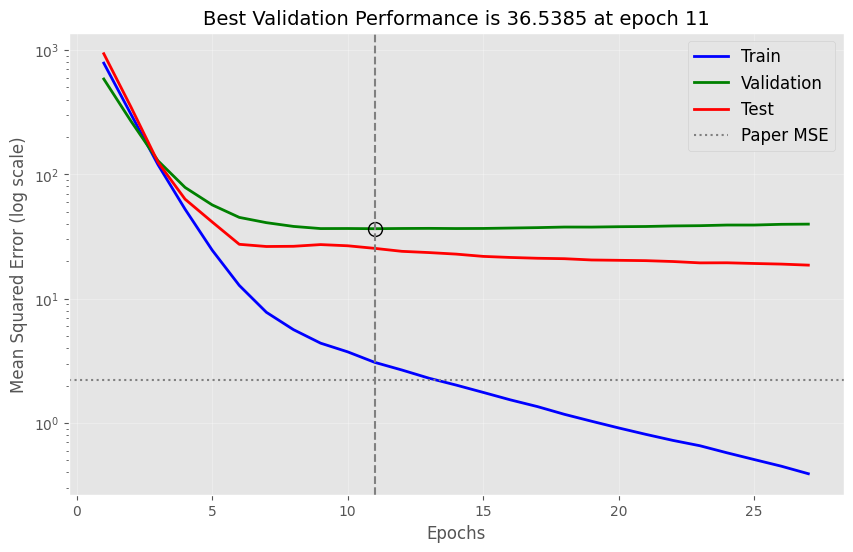

In [23]:

for model_result in results:
    if model_result["Model"] == "Gradient Boosting (Opt)" and len(model_result["Train Errors"]) > 0:
        epochs = list(range(1, 28))
        train_errors = model_result["Train Errors"]
        val_errors = model_result["Val Errors"]
        test_errors = model_result["Test Errors"]

        best_epoch = np.argmin(val_errors) + 1
        best_val = min(val_errors)
        
        plt.figure(figsize=(10, 6))
        plt.semilogy(epochs, train_errors, 'b-', linewidth=2, label='Train')
        plt.semilogy(epochs, val_errors, 'g-', linewidth=2, label='Validation')
        plt.semilogy(epochs, test_errors, 'r-', linewidth=2, label='Test')
        

        plt.plot(best_epoch, best_val, 'go', markersize=10, 
                 markeredgecolor='k', markerfacecolor='none')
        plt.axvline(x=best_epoch, linestyle='--', color='gray')
        

        plt.axhline(y=2.2344, linestyle=':', color='gray', label='Paper MSE')
        
        plt.title(f'Best Validation Performance is {best_val:.4f} at epoch {best_epoch}', fontsize=14)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Mean Squared Error (log scale)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.savefig('gradient_boosting_learning_curve.png', dpi=300)
        plt.show()

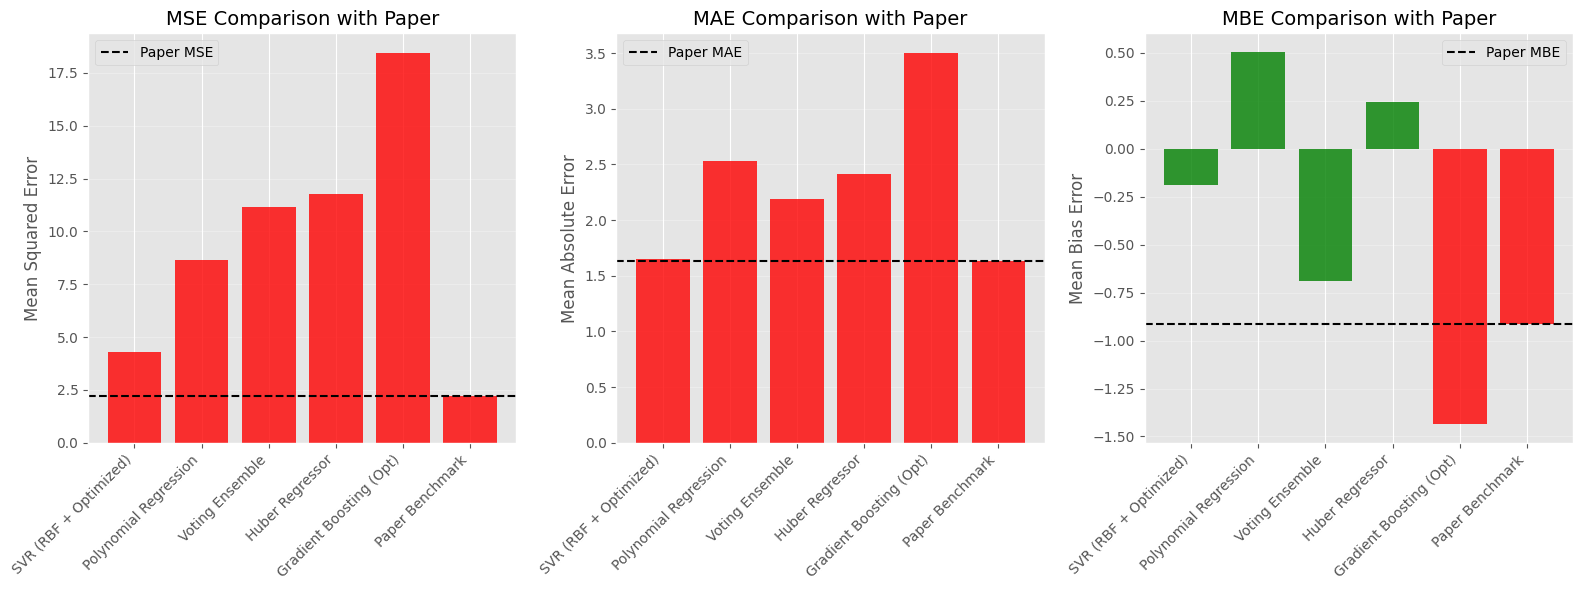

In [24]:

plt.figure(figsize=(16, 6))
models_to_plot = results_df["Model"].tolist()
mse_values = results_df["MSE"].tolist()


plt.subplot(1, 3, 1)
colors = ['green' if mse < 2.2344 else 'red' for mse in mse_values]
bars = plt.bar(models_to_plot, mse_values, color=colors, alpha=0.8)
plt.axhline(y=2.2344, linestyle='--', color='black', label='Paper MSE')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('MSE Comparison with Paper', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.subplot(1, 3, 2)
mae_values = results_df["MAE"].tolist()
colors = ['green' if mae < 1.6350 else 'red' for mae in mae_values]
plt.bar(models_to_plot, mae_values, color=colors, alpha=0.8)
plt.axhline(y=1.6350, linestyle='--', color='black', label='Paper MAE')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.title('MAE Comparison with Paper', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()


plt.subplot(1, 3, 3)
mbe_values = results_df["MBE"].tolist()

colors = ['green' if abs(mbe) < abs(-0.9130) else 'red' for mbe in mbe_values]
plt.bar(models_to_plot, mbe_values, color=colors, alpha=0.8)
plt.axhline(y=-0.9130, linestyle='--', color='black', label='Paper MBE')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Mean Bias Error', fontsize=12)
plt.title('MBE Comparison with Paper', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('error_comparison.png', dpi=300)
plt.show()

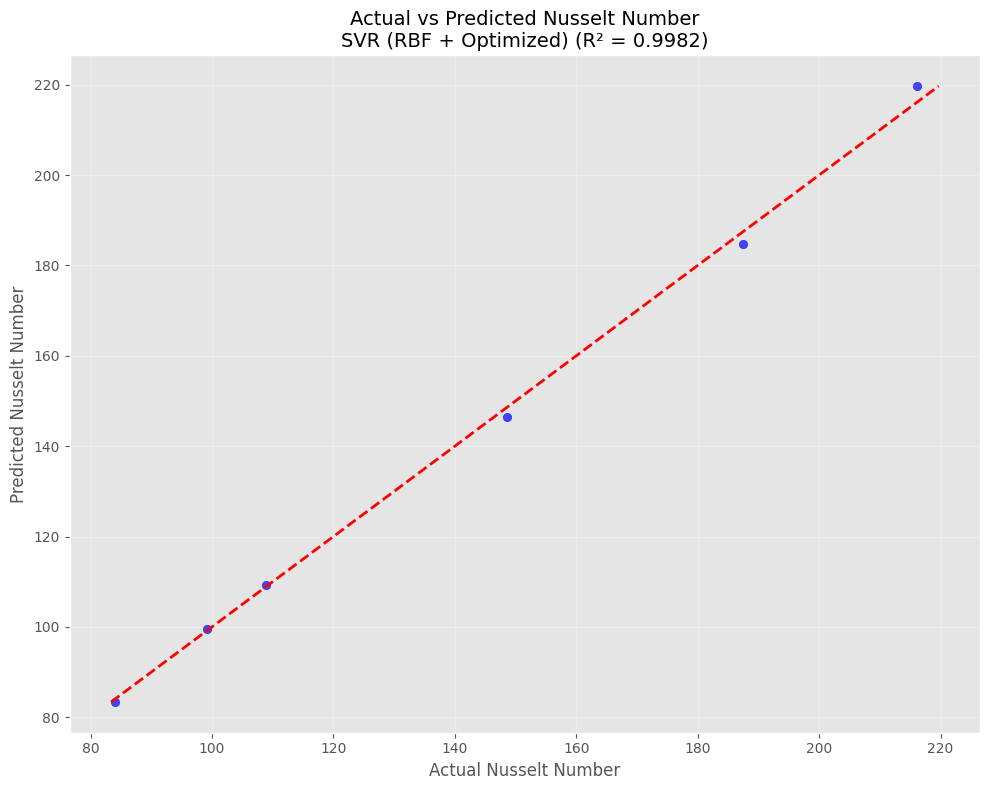

In [25]:

best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']


for result in results:
    if result['Model'] == best_model_name:
        y_pred = result.get('Predictions')
        break


if y_pred is not None:
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
    

    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    plt.xlabel('Actual Nusselt Number', fontsize=12)
    plt.ylabel('Predicted Nusselt Number', fontsize=12)
    plt.title(f'Actual vs Predicted Nusselt Number\n{best_model_name} (R² = {best_model_row["R²"]:.4f})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png', dpi=300)
    plt.show()

In [26]:

best_model = results_df.iloc[0]
print(f"Best performing model: {best_model['Model']}")
print(f"MSE: {best_model['MSE']:.4f} (Paper: 2.2344)")
print(f"MAE: {best_model['MAE']:.4f} (Paper: 1.6350)")
print(f"MBE: {best_model['MBE']:.4f} (Paper: -0.9130)")
print(f"R²: {best_model['R²']:.4f}")


mse_improvement = ((2.2344 - best_model['MSE']) / 2.2344) * 100
mae_improvement = ((1.6350 - best_model['MAE']) / 1.6350) * 100
mbe_improvement = ((abs(-0.9130) - abs(best_model['MBE'])) / abs(-0.9130)) * 100 if abs(-0.9130) > abs(best_model['MBE']) else 0

print(f"\nImprovements over paper:")
print(f"MSE: {mse_improvement:.2f}% better")
print(f"MAE: {mae_improvement:.2f}% better")
print(f"MBE bias reduction: {mbe_improvement:.2f}%")

print("\nAnalysis complete! Check the learning curve and error comparison plots.")

Best performing model: SVR (RBF + Optimized)
MSE: 4.2829 (Paper: 2.2344)
MAE: 1.6544 (Paper: 1.6350)
MBE: -0.1884 (Paper: -0.9130)
R²: 0.9982

Improvements over paper:
MSE: -91.68% better
MAE: -1.18% better
MBE bias reduction: 79.36%

Analysis complete! Check the learning curve and error comparison plots.
